In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('../..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

%matplotlib widget

In [2]:
eSource, NB_PARTICLES, dsArray, repeats = pickle.load(open('data/simargv.pkl', 'rb'))
bins = 250
nbdS = dsArray.size

# Load analog estimators
analogTEE = np.empty((repeats, bins), dtype=float)
for repeat in range(repeats):
    TEE = pickle.load(open(f'data/TEEAnalog_{repeat}.pkl', 'rb'))[0]
    binCenter, binVal = TEE.getDensityData(bins=bins)
    analogTEE[repeat, :] = binVal

KDMCTEE = np.empty((nbdS, repeats, bins), dtype=float)
# Load KDMC estimators
for i in range(nbdS):
    for repeat in range(repeats):
        TEE = pickle.load(open(f'data/TEEKDMC{i}_{repeat}.pkl', 'rb'))[0]
        _, binVal = TEE.getDensityData(bins=bins)
        KDMCTEE[i, repeat, :] = binVal

In [3]:
# Compute exact solution at E = 0 (t = 1)
import electronTransportCode.exactSolution

resy = np.zeros_like(binCenter)
for index, r in enumerate(binCenter):
    resy[index] = electronTransportCode.exactSolution.planeSourceSolution(r, 0.0, eSource)

# Normalize
resy = resy/np.trapz(resy, binCenter)  

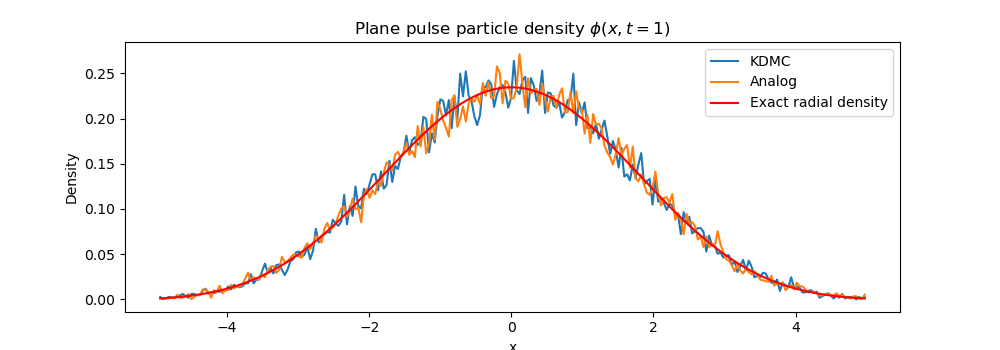

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 3.5))

ax1.plot(binCenter, KDMCTEE[0, 0, :], label='KDMC')
ax1.plot(binCenter, analogTEE[0, :], label='Analog')
ax1.plot(binCenter, resy, color='r', label='Exact radial density')

ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.set_title('Plane pulse particle density $\phi(x, t=1)$')
ax1.legend()

In [5]:
# Compute error of distributions
KDMCErr = np.empty(shape=(nbdS, repeats))
analogErr = np.empty(shape=(repeats))
for repeat in range(repeats):
    analogErr[repeat] = stats.wasserstein_distance(resy, analogTEE[repeat, :])
    for i in range(nbdS):
        KDMCErr[i, repeat] = stats.wasserstein_distance(resy, KDMCTEE[i, repeat, :])

# Average over repeats
KDMCAvgErr = KDMCErr.mean(axis=1)
analogAvgErr = analogErr.mean()

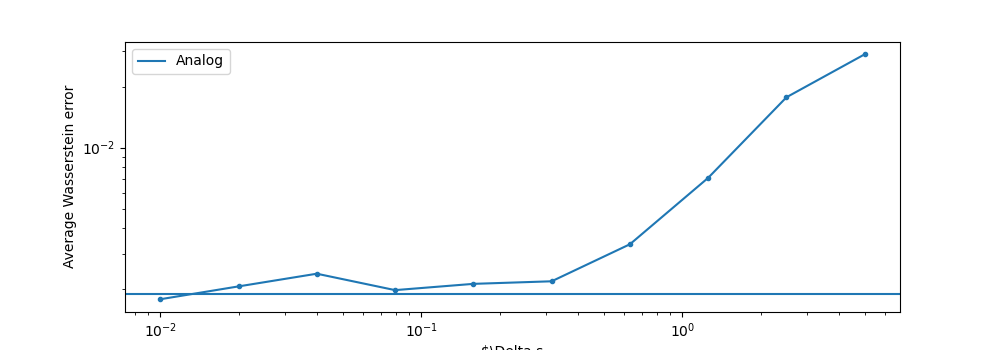

In [6]:
# Plot error
fig, ax1 = plt.subplots(figsize=(10, 3.5))

ax1.loglog(dsArray, KDMCAvgErr, '.-')
ax1.axhline(y=analogAvgErr, label='Analog')

ax1.set_xlabel('$\Delta s')
ax1.set_ylabel('Average Wasserstein error')
ax1.legend()
